In [31]:
import kagglehub
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os

imports

In [32]:
path = kagglehub.dataset_download("mashlyn/online-retail-ii-uci")

df = pd.read_csv(os.path.join(path, "online_retail_II.csv"))   
def data_inv(df):
    print("Number of rows:",df.shape[0])
    print("Dataset variables:", df.shape[1])
    print("-"*10)
    print("Dataset columns:\n")
    print(df.columns)
    print("-"*10)
    print('data-type of each column: \n')
    print(df.dtypes)
    print('-'*10)
    print('missing rows in each column: \n')
    c=df.isnull().sum()
    print(c[c>0])
    print('-'*10)
    print(df.head())
    print('-'*10)
    print(df.tail())

In [33]:
data_inv(df)

Number of rows: 1067371
Dataset variables: 8
----------
Dataset columns:

Index(['Invoice', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'Price', 'Customer ID', 'Country'],
      dtype='object')
----------
data-type of each column: 

Invoice         object
StockCode       object
Description     object
Quantity         int64
InvoiceDate     object
Price          float64
Customer ID    float64
Country         object
dtype: object
----------
missing rows in each column: 

Description      4382
Customer ID    243007
dtype: int64
----------
  Invoice StockCode                          Description  Quantity  \
0  489434     85048  15CM CHRISTMAS GLASS BALL 20 LIGHTS        12   
1  489434    79323P                   PINK CHERRY LIGHTS        12   
2  489434    79323W                  WHITE CHERRY LIGHTS        12   
3  489434     22041         RECORD FRAME 7" SINGLE SIZE         48   
4  489434     21232       STRAWBERRY CERAMIC TRINKET BOX        24   

           InvoiceDa

The part where we analyze the data

In [34]:
# Convert InvoiceDate to datetime
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
#Customer ID' has so much missing values
df = df[df['Customer ID'].notna()]
df['Customer ID'] = df['Customer ID'].astype(np.int64) #Not float
#New column
df['TotalPrice'] = df['Quantity'] * df['Price']

I am cleaning up the data by changing the types and performing operations on unknown columns.

In [35]:
# Min and Max value check
max_value = df[df['TotalPrice'] == df['TotalPrice'].max()]
min_value = df[df['TotalPrice'] == df['TotalPrice'].min()]

In [36]:
# After checking, removing negative quantities
df = df[df['Quantity'] > 0]

I am checking the maximum and minimum values. During the check, the value statuses are displayed. In the TotalPrice column, I am selecting those with a Quantity value greater than 0 to ensure there are no values.

Which countries are the most active in terms of sales?

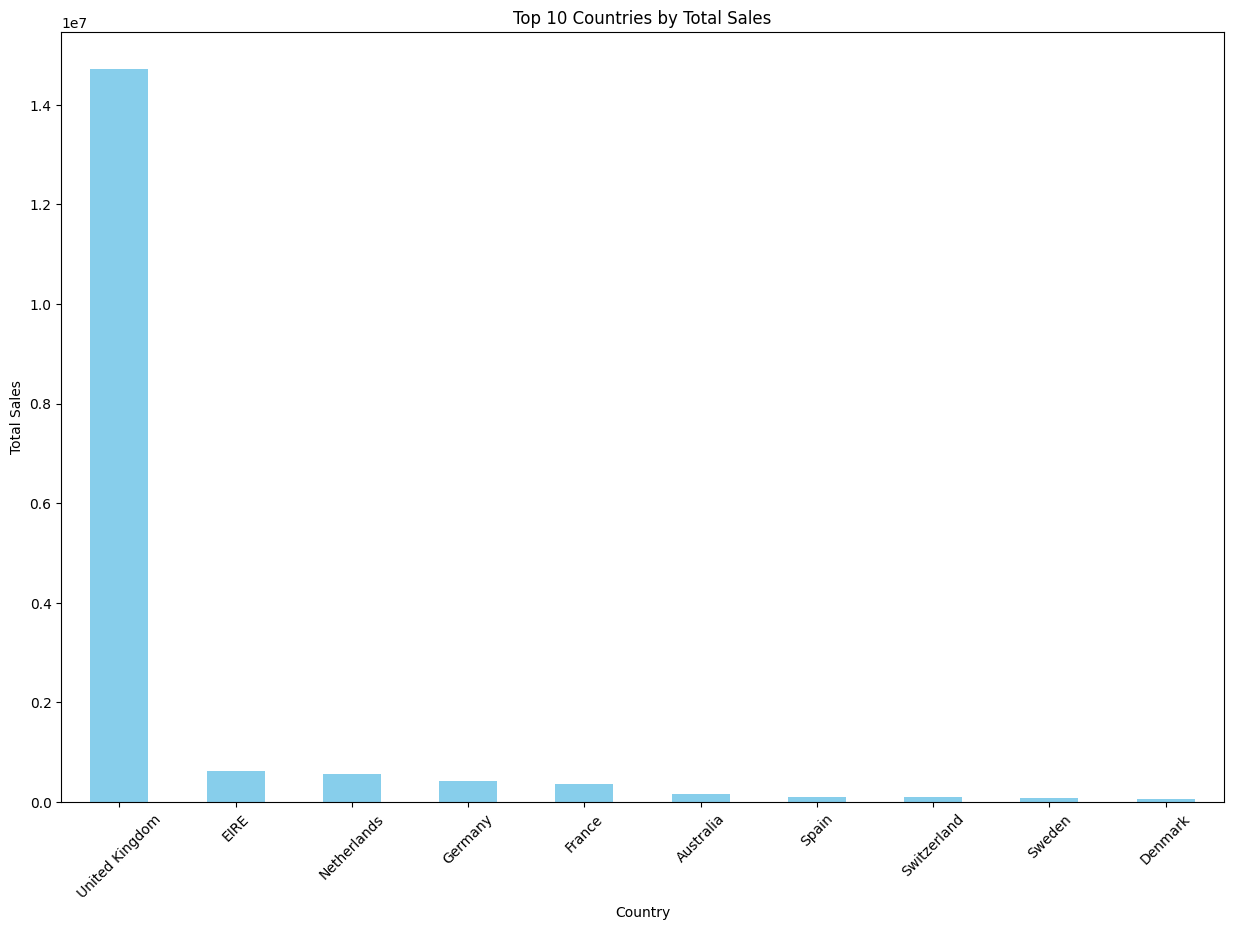

In [37]:
# Top 10 Countries by Total Sales
df.groupby('Country')['TotalPrice'].sum().sort_values(ascending=False).head(10).plot(kind='bar', color='skyblue',figsize=(15,10)),
plt.title('Top 10 Countries by Total Sales')
plt.xlabel('Country')
plt.xticks(rotation=45)
plt.ylabel('Total Sales')
plt.show()


Countries with the most customers

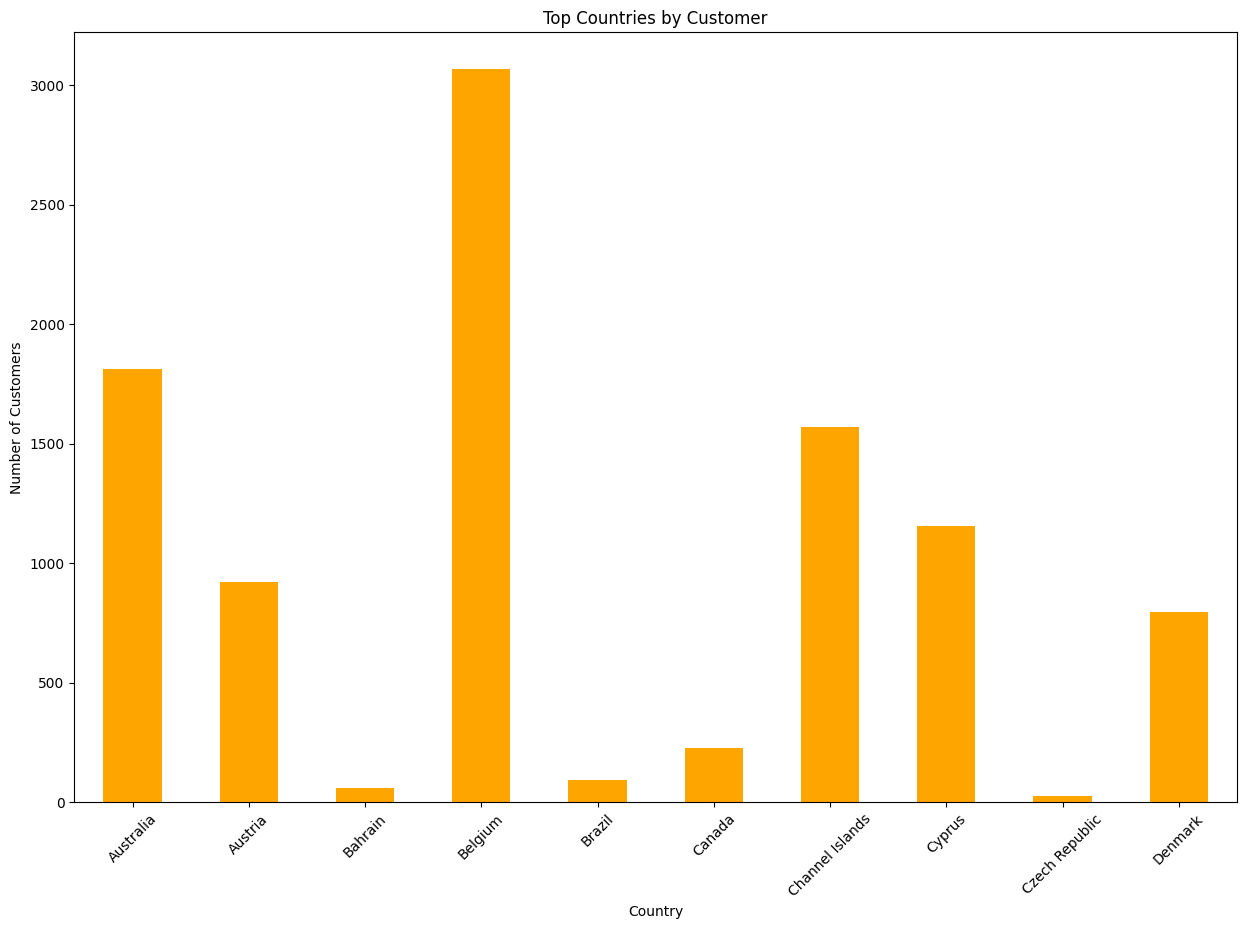

In [38]:
# Top 10 Countries by Customer Count
df.groupby('Country')['Customer ID'].count().head(10).plot(kind='bar', color='orange', figsize=(15, 10))
plt.title('Top Countries by Customer')
plt.xlabel('Country')
plt.xticks(rotation=45)
plt.ylabel('Number of Customers')
plt.show()  

Customer IDs with the highest spending

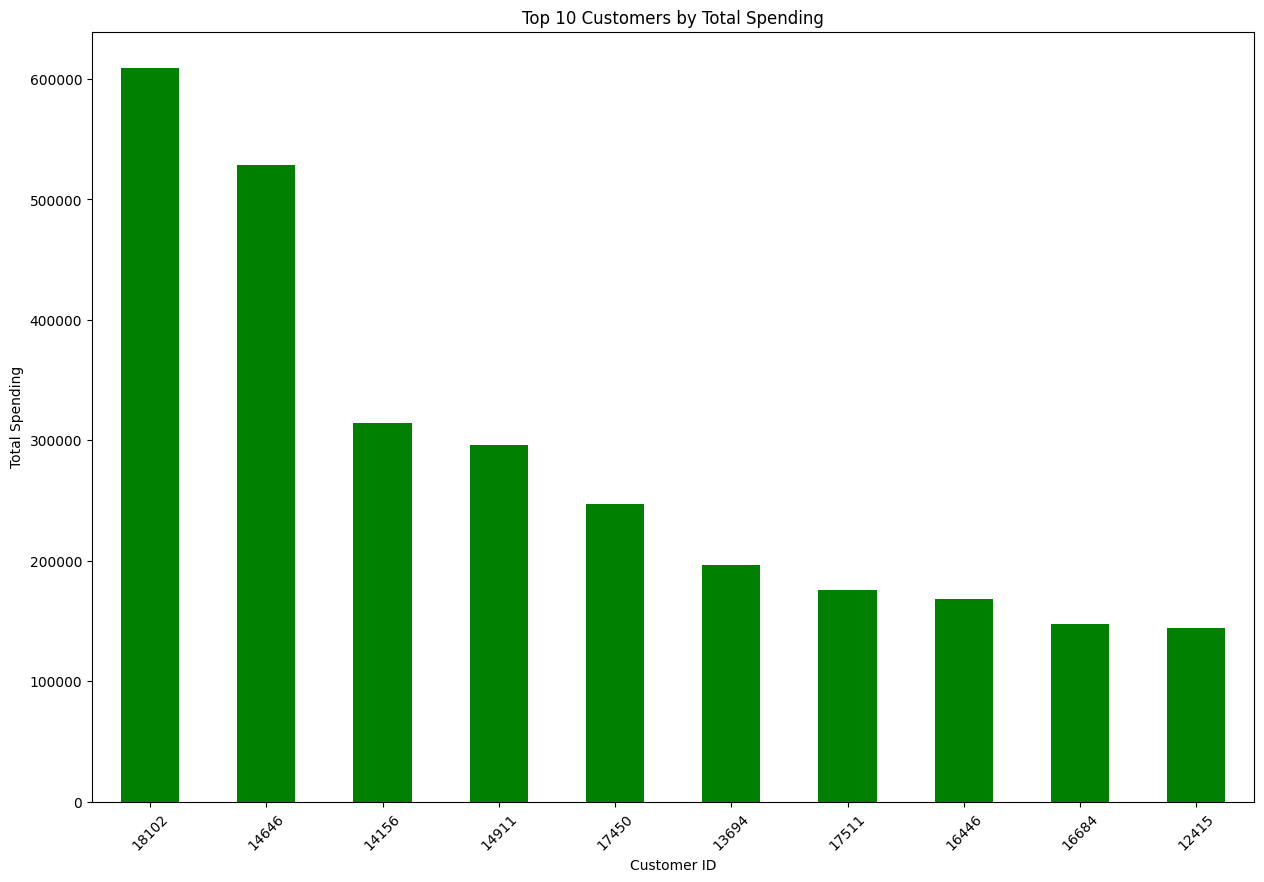

In [39]:
# Top 10 Customers by Total Spending
df.groupby('Customer ID')['TotalPrice'].sum().sort_values(ascending=False).head(10).plot(kind='bar', color='green', figsize=(15, 10))
plt.title('Top 10 Customers by Total Spending')
plt.xlabel('Customer ID')
plt.xticks(rotation=45)
plt.ylabel('Total Spending')
plt.show()

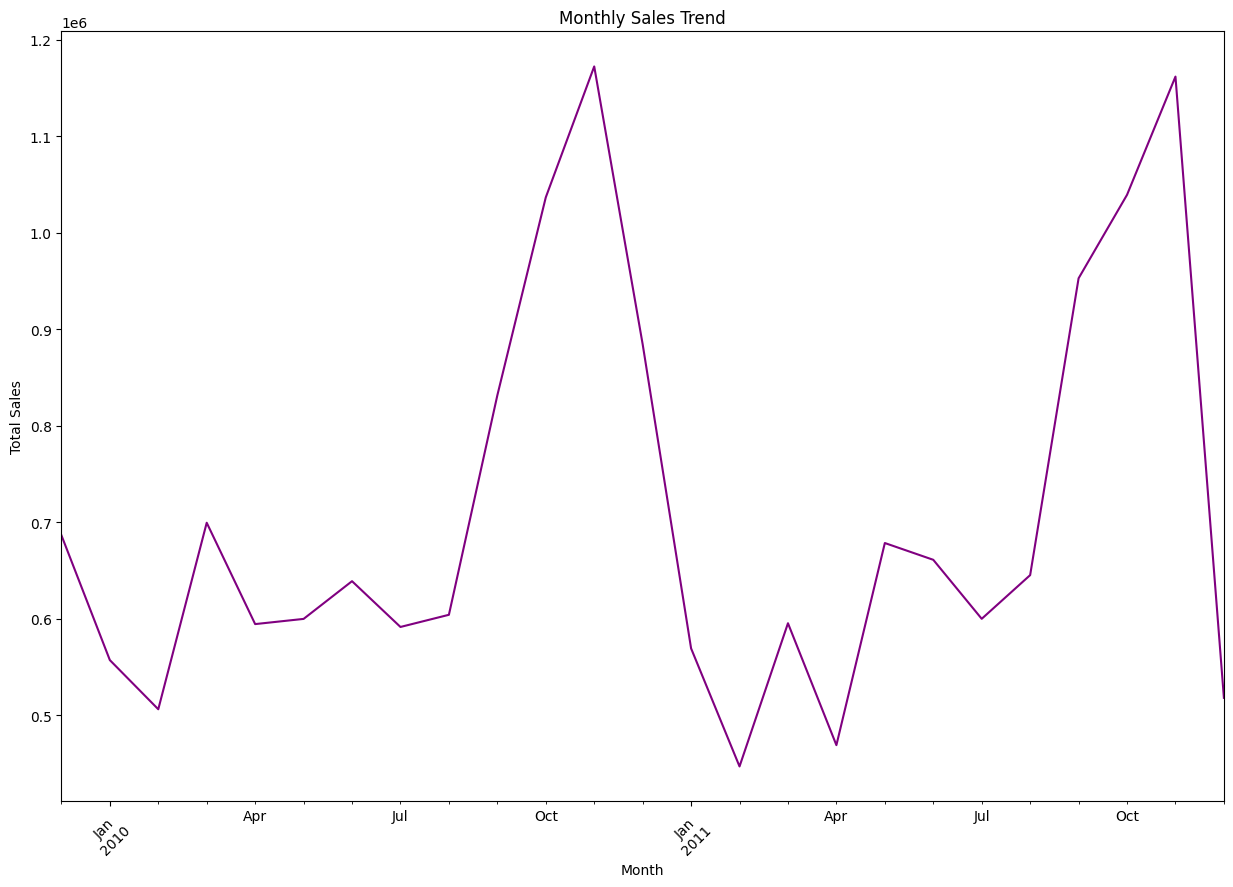

In [46]:
#Monthly Sales Trend
new_df = df.set_index('InvoiceDate', inplace=False)
new_df = new_df.resample('ME')['TotalPrice'].sum().plot(kind='line', color='purple', figsize=(15, 10))
plt.title('Monthly Sales Trend')
plt.xlabel('Month')
plt.ylabel('Total Sales')
plt.xticks(rotation=45)
plt.show()

Trend sales range by month

In [41]:
#RFM
#Recency
today = df['InvoiceDate'].max() + pd.DateOffset(days=1)
df['Recency'] = (today - df.groupby('Customer ID')['InvoiceDate'].transform('max')).dt.days
#Frequency
df['Frequency'] = df.groupby('Customer ID')['InvoiceDate'].transform('nunique')
#Monetary
df['Monetary'] = df.groupby('Customer ID')['TotalPrice'].transform('sum')

df_rfm = df[['Customer ID', 'Recency', 'Frequency', 'Monetary']].drop_duplicates().set_index('Customer ID')

In [42]:
#RFM Score
df_rfm['Recency_Score'] = pd.qcut(df_rfm['Recency'], 3, labels=['3', '2', '1'])
df_rfm['Frequency_Score'] = pd.qcut(df_rfm['Frequency'], 3, labels=['1', '2', '3'])
df_rfm['Monetary_Score'] = pd.qcut(df_rfm['Monetary'], 3, labels=['1', '2', '3'])
df_rfm['RFM_Score'] = (df_rfm['Recency_Score'].astype(str) + df_rfm['Frequency_Score'].astype(str) + df_rfm['Monetary_Score'].astype(str))

RFM scores are important data for machine learning.

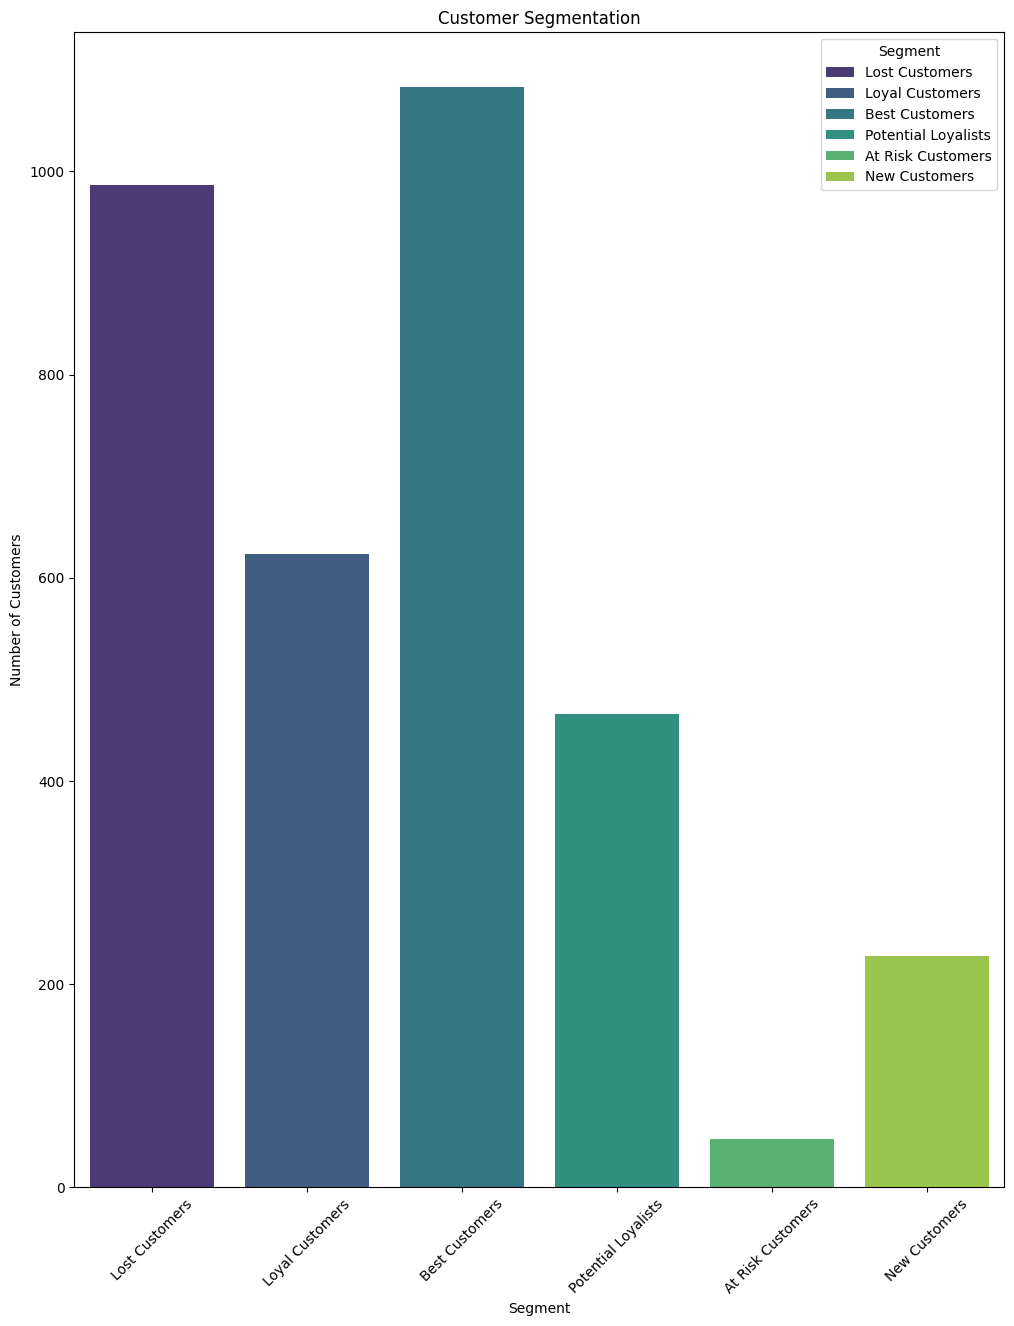

In [43]:
#Segmentasyon 
segment_map = {
    '111': 'Best Customers',
    '211': 'Loyal Customers',
    '311': 'New Customers',
    '221': 'Potential Loyalists',
    '222': 'Potential Loyalists',
    '223': 'Loyal Customers',
    '321': 'At Risk Customers',
    '333': 'Lost Customers'
}

df_rfm['Segment'] = df_rfm['RFM_Score'].map(segment_map)
plt.figure(figsize=(12, 15))
sns.countplot(x='Segment', data=df_rfm, hue='Segment', palette='viridis')
plt.title('Customer Segmentation')
plt.xlabel('Segment')
plt.ylabel('Number of Customers')
plt.xticks(rotation=45)
plt.show()

After segmentation, we see that we have a large number of best customers, but at the same time, we are losing a significant number of customers. Processes can be implemented to reduce the number of customers in the high-risk segment and to acquire new customers.

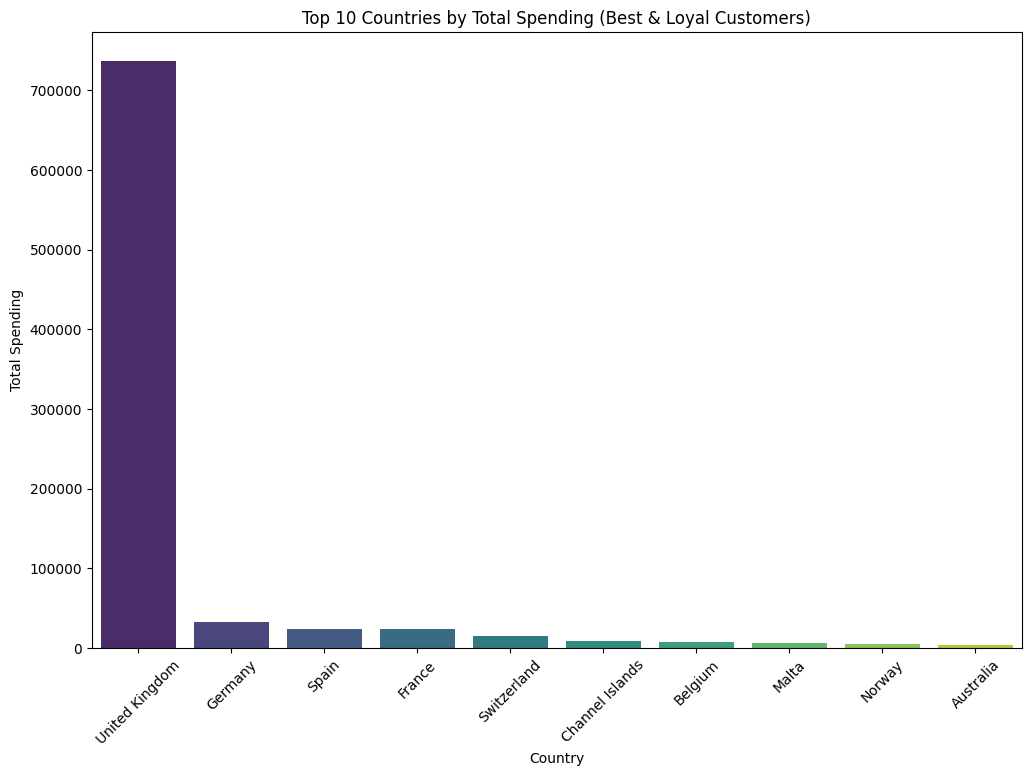

In [ ]:
# En iyi ve sadık müşterilerin olduğu şehirler
best_customers = df_rfm[df_rfm['Segment'].isin(['Best Customers', 'Loyal Customers'])].copy()
best_customers['Customer ID'] = best_customers.index

best_customers_transactions = df[df['Customer ID'].isin(best_customers['Customer ID'])]
top10country = best_customers_transactions.groupby('Country')['TotalPrice'].sum().sort_values(ascending=False).head(10)

plt.figure(figsize=(12, 8))
sns.barplot(x=top10country.index, y=top10country.values,hue=top10country.index, palette='viridis')
plt.title('Top 10 Countries by Total Spending (Best & Loyal Customers)')
plt.xlabel('Country')
plt.ylabel('Total Spending')
plt.xticks(rotation=45)
plt.show()

In which cities is the concentration of loyal customers learned?

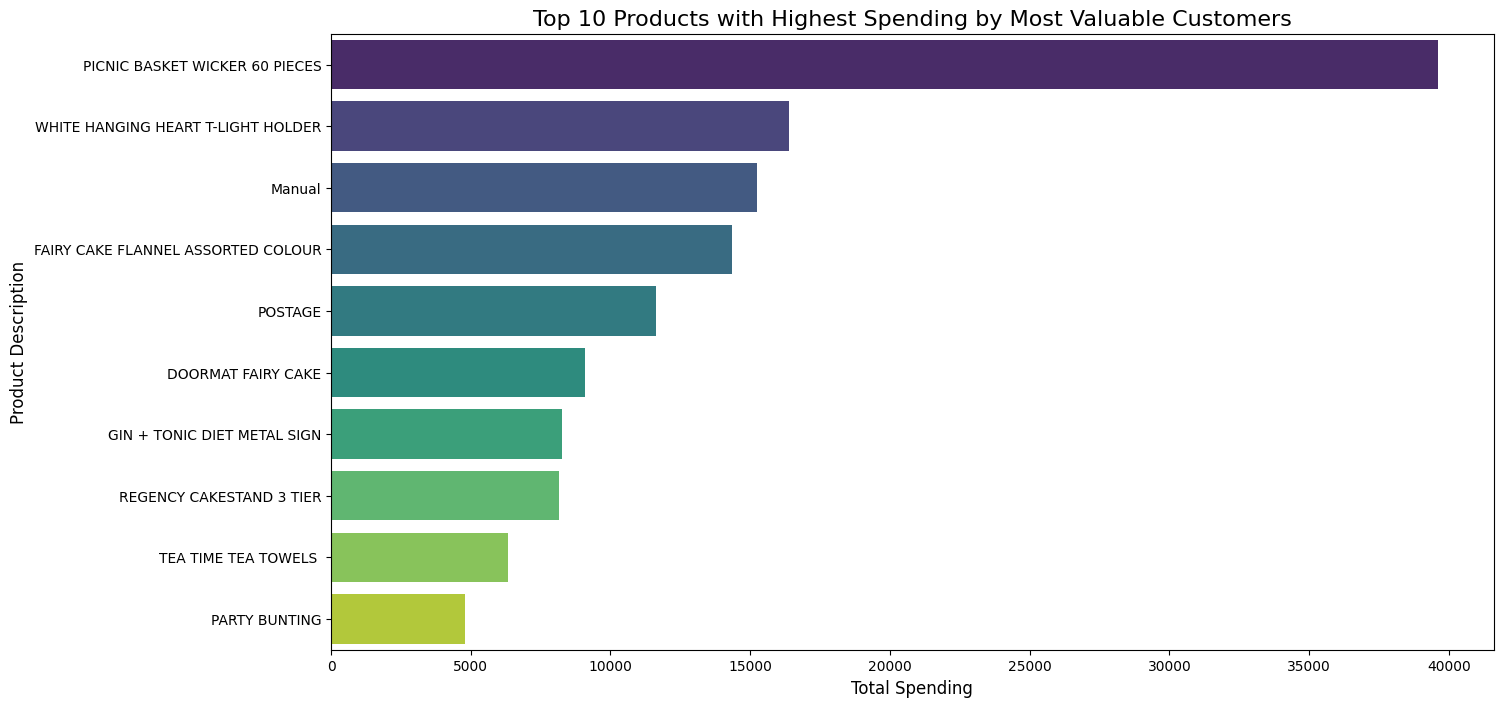

In [49]:
#Ürün tercihleri
best_customers_products = best_customers_transactions.groupby('Description')['TotalPrice'].sum().sort_values(ascending=False).head(10)

plt.figure(figsize=(15, 8))
sns.barplot(x=best_customers_products.values, y=best_customers_products.index,hue=best_customers_products.index, palette='viridis')
plt.title('Top 10 Products with Highest Spending by Most Valuable Customers', fontsize=16)
plt.xlabel('Total Spending', fontsize=12)
plt.ylabel('Product Description', fontsize=12)
plt.show()


Which products do these loyal customers spend the most on?

In the future, campaign option values will be calculated when machine learning and products are added.